In [69]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib

In [70]:
IMAGE_SIZE = 256
BATCH_SIZE = 32  
CHANNELS =3

In [71]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 2152 files belonging to 3 classes.


In [72]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [73]:
len(dataset)

68

In [74]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0])

(32, 256, 256, 3)
[0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 2 1 1]
tf.Tensor(
[[[113. 109. 123.]
  [115. 111. 125.]
  [120. 116. 130.]
  ...
  [135. 132. 143.]
  [127. 124. 135.]
  [132. 129. 140.]]

 [[116. 112. 126.]
  [117. 113. 127.]
  [116. 112. 126.]
  ...
  [138. 135. 146.]
  [120. 117. 128.]
  [119. 116. 127.]]

 [[121. 117. 131.]
  [122. 118. 132.]
  [121. 117. 131.]
  ...
  [146. 143. 154.]
  [139. 136. 147.]
  [141. 138. 149.]]

 ...

 [[192. 190. 201.]
  [185. 183. 194.]
  [193. 191. 202.]
  ...
  [193. 195. 207.]
  [188. 190. 202.]
  [184. 186. 198.]]

 [[187. 185. 196.]
  [196. 194. 205.]
  [204. 202. 213.]
  ...
  [192. 194. 206.]
  [192. 194. 206.]
  [192. 194. 206.]]

 [[192. 190. 201.]
  [206. 204. 215.]
  [205. 203. 214.]
  ...
  [188. 190. 202.]
  [193. 195. 207.]
  [197. 199. 211.]]], shape=(256, 256, 3), dtype=float32)


2024-05-08 18:47:42.330041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [75]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2024-05-08 18:47:42.636725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


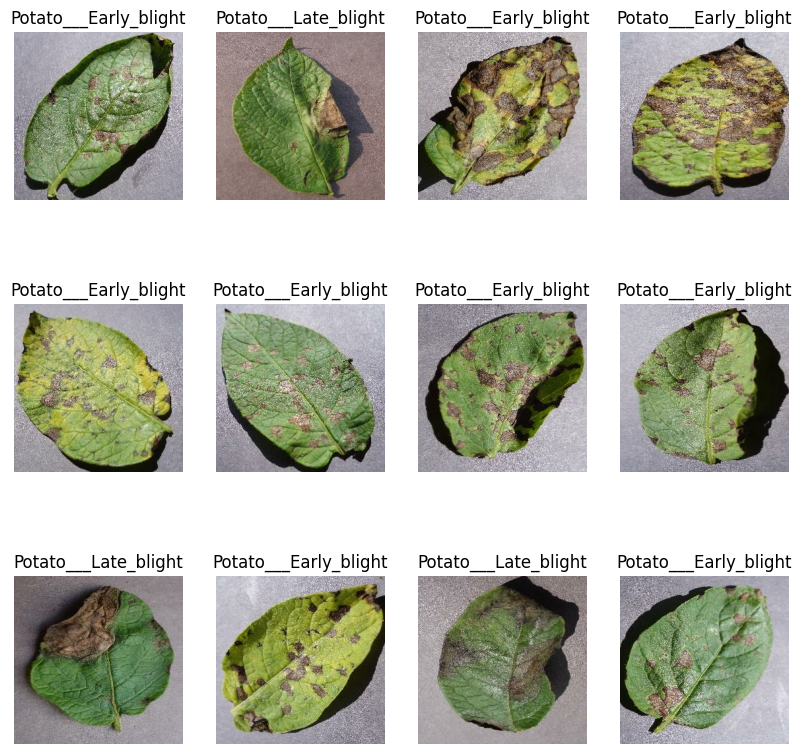

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [77]:
# train_ds=dataset.take(int(len(dataset)*0.8))
# test_ds = dataset.skip(54)
# val_ds=test_ds.take(int(len(dataset)*0.1))

In [78]:
#Split dataset into train and test:
def get_ds_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=dataset.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,ds_size,test_ds

In [79]:
train_ds,val_ds,ds_size,test_ds=get_ds_partitions_tf(dataset)

In [80]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [81]:
#Setting for saving time training models
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [82]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [83]:
#Make more data to train
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [84]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [85]:
#Build model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

/Users/mac/Desktop/DE_PJ/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [88]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 714ms/step - accuracy: 0.4918 - loss: 0.9232 - val_accuracy: 0.5060 - val_loss: 0.8976
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 681ms/step - accuracy: 0.6689 - loss: 0.7190 - val_accuracy: 0.6548 - val_loss: 0.9893
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 684ms/step - accuracy: 0.7960 - loss: 0.4923 - val_accuracy: 0.7321 - val_loss: 0.6720
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 678ms/step - accuracy: 0.8669 - loss: 0.3352 - val_accuracy: 0.8274 - val_loss: 0.4050
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 683ms/step - accuracy: 0.8870 - loss: 0.2915 - val_accuracy: 0.8452 - val_loss: 0.4097
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 665ms/step - accuracy: 0.9075 - loss: 0.2229 - val_accuracy: 0.8393 - val_loss: 0.4124
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 672ms/step - accuracy: 0.9103 - loss: 0.2351 - val_accuracy: 0.9048 - val_loss: 0.2270
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 672ms/step - accuracy: 0.9321 - loss: 0.1630 - val_accu

In [93]:
score = model.evaluate(test_ds)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.9861 - loss: 0.0595


[0.05083277076482773, 0.98828125]

In [90]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [94]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

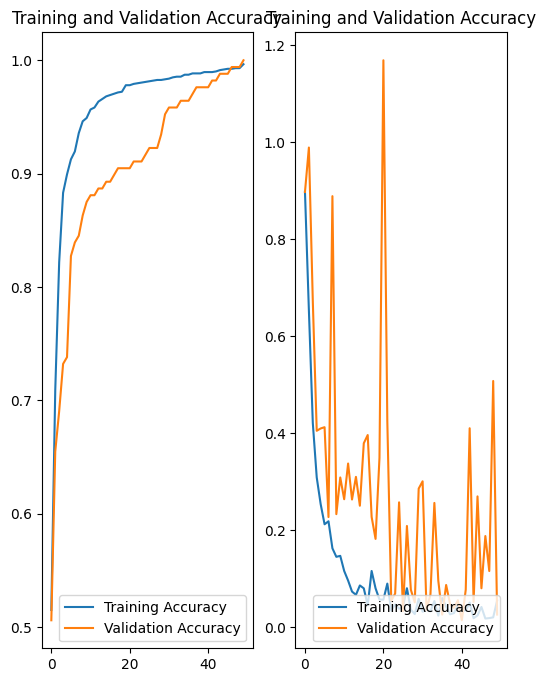

In [105]:
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.plot(range(50),sorted_acc,label="Training Accuracy")
plt.plot(range(50),sorted_val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50),loss,label="Training Accuracy")
plt.plot(range(50),val_loss,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
predicted label: Potato___Early_blight


2024-05-08 19:43:48.522210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


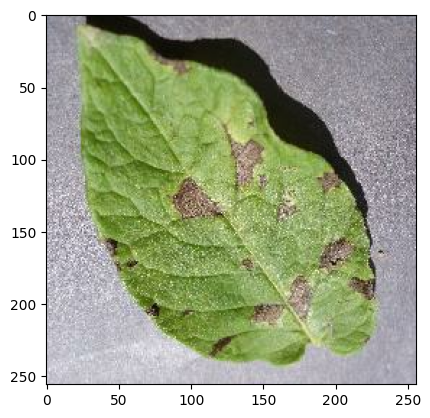

In [106]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [107]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-05-08 20:07:38.002501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


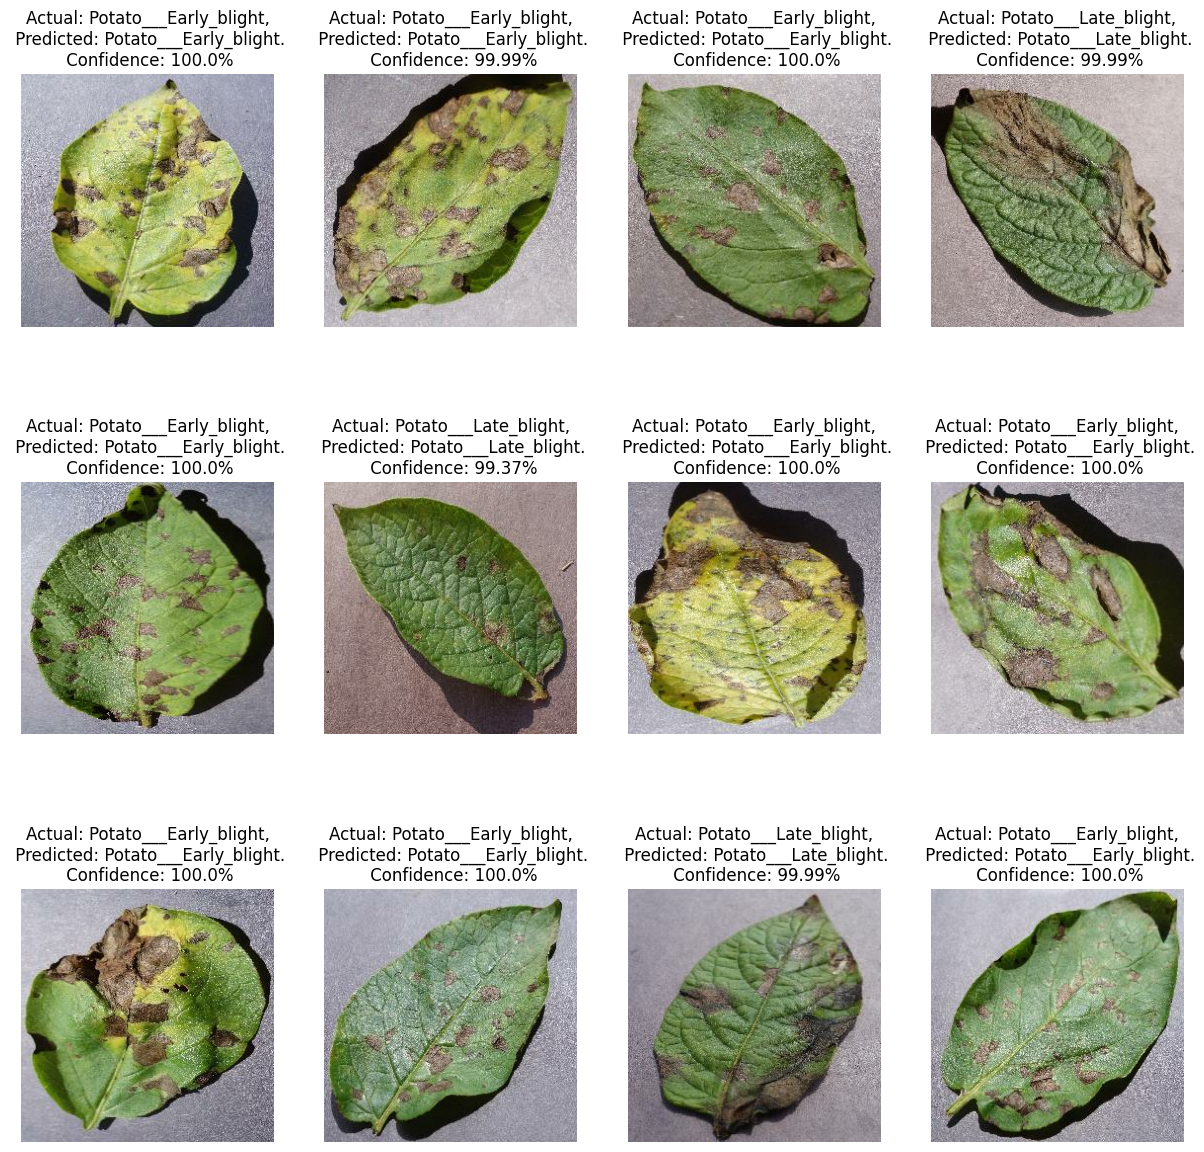

In [109]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [127]:
import os
from tensorflow.keras.models import save_model

save_dir = 'Models_Potato'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, 'my_model_potato.keras'))
print(os.listdir(save_dir))


['my_model_potato.keras', 'fingerprint.pb', 'variables', 'my_model.keras', 'saved_model.pb', 'assets']


In [124]:
from tensorflow.keras.models import load_model
import os

# Directory where the model is saved
save_dir = 'Models_Potato'

# Load the model
loaded_model = load_model(os.path.join(save_dir, 'my_model.keras'))

# Check model summary
model.export(os.path.join(save_dir))

INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


Saved artifact at 'Models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_75')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5280434512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5280433360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5280438736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5280434896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5280435664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5280437968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5276697424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5276701264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5276700496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5276702800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5276698960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  527670